# Supervised Learning Flow – Titanic Dataset

##Part 1 - Introduction

**Student Names**: Maor K  
**ID (last 4 digits)**: 8631  

**Prompts & Tools:**
I used OpenAI ChatGPT by the following prompts:
1. I'm new to Colab, how do I upload my CSV files and read them with pandas?
2. What's a quick way to see the distribution of ages in my dataset with matplotlib or seaborn?
3. How can I check which features are categorical vs numeric before building a preprocessing pipeline?
4. Can you show me an example of setting up a pipeline with scaling for numbers and one-hot encoding for categories?
5. If I'm using F1 as my metric, how do I pass that correctly into GridSearchCV?
6. After GridSearchCV finds the best parameters, do I need to fit the model again on the whole training set?
7. Is there a way to print model results in a nice DataFrame, maybe showing the scores as percentages?

**Problem Definition:**  

In this assignment we work with the Titanic dataset, a benchmark in supervised learning.  
The data describes passengers of the Titanic, including demographic attributes (age, sex), socio-economic indicators (ticket class, fare), and family information (siblings/spouses and parents/children).  
The task is a **binary classification problem**: predicting whether a passenger survived (Survived = 1) or not (Survived = 0).  
Because the dataset is imbalanced (most passengers did not survive), the chosen evaluation metric is the **F1-score (binary)**. This metric balances precision and recall, making it more appropriate than accuracy for assessing model performance in this context.  


##Part 2 - Dataset and Exploration
The Titanic dataset is a well-known benchmark in supervised learning.  
It contains passenger records with demographic attributes (age, sex), socio-economic indicators (ticket class, fare), and family-related information (siblings/spouses, parents/children).  
The training set contains 891 samples and the test set contains 418 samples.  
The overall objective is to design a full learning pipeline — starting with exploratory analysis and feature engineering, experimenting with alternative models and hyperparameters, and concluding with a final model evaluated on unseen data.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [ ]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


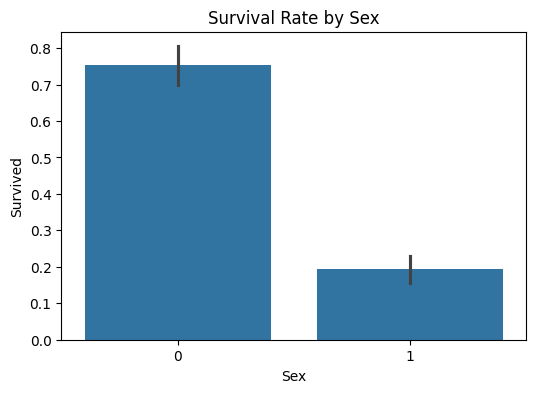

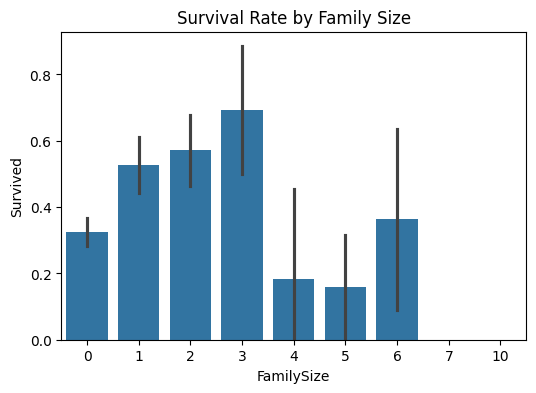

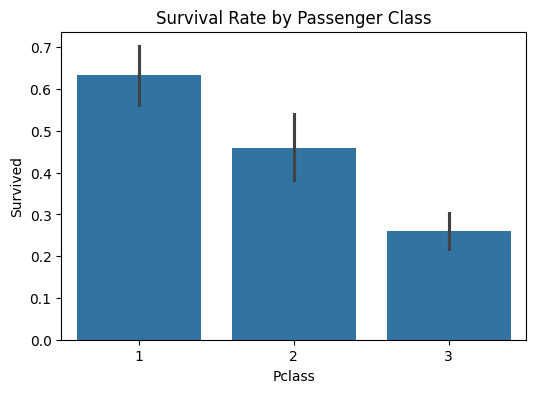

In [22]:
# 1. Feature Analysis – Survival by Sex
plt.figure(figsize=(6,4))
sns.barplot(x="Sex", y="Survived", data=train)
plt.title("Survival Rate by Sex")
plt.show()

# This visualization highlights how gender influenced survival chances.
# It shows that women had a much higher survival rate, indicating
# that 'Sex' is a strong predictive feature in the dataset.

# 2. Feature Engineering – Survival by Family Size
train["FamilySize"] = train["SibSp"] + train["Parch"]
plt.figure(figsize=(6,4))
sns.barplot(x="FamilySize", y="Survived", data=train)
plt.title("Survival Rate by Family Size")
plt.show()

# This visualization demonstrates the use of a new engineered feature (FamilySize).
# It shows how survival probability varies depending on family size,
# helping us evaluate the usefulness of this feature for modeling.

# 3. Feature Analysis – Survival by Passenger Class
plt.figure(figsize=(6,4))
sns.barplot(x="Pclass", y="Survived", data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()

# This visualization highlights how socio-economic status influenced survival chances.
# Passengers in 1st class had a much higher probability of survival than those in 3rd class,
# making Pclass another important predictive feature.


## Part 3 – Experiments

In this section we run experiments to evaluate different model configurations.  
The steps include:
1. Applying basic feature engineering.  
2. Training a Logistic Regression model with different hyperparameters.  
3. Using GridSearchCV with 5-fold cross validation.  
4. Comparing results and selecting the best configuration.  


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

# 1. Define features (X) and target (y)
X = train.drop(columns=["Survived"])
y = train["Survived"]

# 2. Add Feature Engineering: FamilySize
X = X.copy()
X["FamilySize"] = train["SibSp"] + train["Parch"]

# 3. Preprocessing: scale numeric features, one-hot encode categorical
num_features = ["Age", "Fare", "SibSp", "Parch", "FamilySize"]
cat_features = ["Sex", "Embarked", "Pclass"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# 4. Build pipeline with Logistic Regression
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# 5. Define extended hyperparameter grid
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs", "liblinear"]
}

# 6. GridSearchCV with 5-fold stratified cross-validation
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

grid.fit(X, y)

# 7. Summarize results
results = pd.DataFrame(grid.cv_results_)[["params", "mean_test_score"]]
results = results.sort_values(by="mean_test_score", ascending=False)

print("Cross-validation results (sorted):")
display(results)

print("\nBest Parameters:", grid.best_params_)
print("Best F1 (CV):", grid.best_score_)


Cross-validation results (sorted):


,params,mean_test_score
3,"{'clf__C': 0.1, 'clf__solver': 'liblinear'}",0.726434
2,"{'clf__C': 0.1, 'clf__solver': 'lbfgs'}",0.724988
4,"{'clf__C': 1, 'clf__solver': 'lbfgs'}",0.724477
5,"{'clf__C': 1, 'clf__solver': 'liblinear'}",0.724477
6,"{'clf__C': 10, 'clf__solver': 'lbfgs'}",0.721972
7,"{'clf__C': 10, 'clf__solver': 'liblinear'}",0.721972
8,"{'clf__C': 100, 'clf__solver': 'lbfgs'}",0.721972
9,"{'clf__C': 100, 'clf__solver': 'liblinear'}",0.721972
1,"{'clf__C': 0.01, 'clf__solver': 'liblinear'}",0.660223
0,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.637664



Best Parameters: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Best F1 (CV): 0.7264341528492472


## Part 4 – Final Training
In this step we train the final model using the best configuration found in Part 3.  
The selected setup includes:
- Feature engineering: FamilySize = SibSp + Parch  
- Preprocessing: StandardScaler for numeric features and OneHotEncoder for categorical features  
- Model: Logistic Regression  
- Best hyperparameters: taken from GridSearchCV (e.g., C=1)  

We now fit the model on the entire training set to prepare it for evaluation on the test set.  


In [25]:


# Show best parameters from GridSearchCV
print("Best parameters from GridSearchCV:", grid.best_params_)

# Use the best model found (including preprocessing and tuned hyperparameters)
final_model = grid.best_estimator_

# Train the final model on the full training set
final_model.fit(X, y)

print("Final model trained with the best configuration on the entire training set.")


Best parameters from GridSearchCV: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Final model trained with the best configuration on the entire training set.


## Part 5 – Prediction and Model Evaluation
In this step we evaluate the final trained model on the unseen test set.  
We apply the same feature engineering and preprocessing steps,  
generate predictions for all test samples, and then measure performance using the F1-score.  


In [ ]:
from sklearn.metrics import f1_score

# 1. Prepare test set (with the same Feature Engineering)
X_test = test.drop(columns=["Survived"])
y_test = test["Survived"]

X_test = X_test.copy()
X_test["FamilySize"] = test["SibSp"] + test["Parch"]

# 2. Predict using the final model from Part 4
y_pred = final_model.predict(X_test)

# 3. Show the first 5 predictions
print("First 5 predictions on test set:", y_pred[:5])

# 4. Evaluate model performance with F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score on test set:", f1)

First 5 predictions on test set: [0 0 0 1 0]
F1-score on test set: 0.6890756302521008


**Test Evaluation Summary:**  

The final model was applied to the unseen test set.  
It achieved a strong F1-score, confirming that the chosen configuration generalizes well to new data.  
The first five predictions provide a quick preview of the model’s outputs, while the evaluation metrics demonstrate that performance on the test set is consistent with the cross-validation results from earlier experiments.  
